## Planejamento do processo

### Definição do problema

#### Definir o problema a ser respondido com máxima precisão

Objetivo estratégico: 

    I - Identificar MCU dos parceiros que são considerados outliers em consultas

Objetivo estratégico: 
    
    Sendo, o 'custo total' de consulta por proposta, uma das variáveis que compõe a [MCU](https://sebrae.com.br/sites/PortalSebrae/artigos/margem-de-contribuicao-voce-sabe-calcular,24d2b05a4c7c3810VgnVCM100000d701210aRCRD), definiremos quando esta variável começa a influenciar negativamente o MCU. Consideraremos **prejuízo** as propostas que retornarem MCU <= 0.00.

Para tanto, aplicaremos a seguinte fórmula:

$$MCU = PVU – (CVU + DVU)$$


Sendo:

**Preço de Venda Unitário (PVU)**: O valor pelo qual você vende uma unidade do seu produto ou serviço. 

**Custo Variável Unitário (CVU)**: Os gastos que variam diretamente com a produção ou venda de uma unidade do produto. 

**Despesa Variável Unitária (DVU)**: Gastos que também variam conforme a produção ou a venda, mas não estão diretamente ligados ao custo de produção em si.




#### Modelar os testes de hipóteses inicialmente necessários para confirmação do problema


1 - Correlacáo entre o volume de consultas e propostas pagas:
    H0: O volume de consultas é altamente correlacionado ä quantidade de propostas pagas.

#### Definir as métricas de validação e acompanhamento da solução

Inicialmente, a MCU será usada como métrica de acompanhamento de eficiência do parceiro, para fins de consulta.

### Verificação dos dados

#### Definir quais dados são necessários

I - Dados de consultas

II - Dados das propostas importadas


#### Como podem ser acessados

I - Dados de consultas


Estão hospedados no clickhouse, acessados pela integração com o debeaver.


II - Dados das propostas importadas


Estão hospedados num DB postgres na cloud, acessados pela integração com o debeaver.


#### Qual é o período definido para análise

Será analisado o histórico de produção dos últimos 12 meses.

#### Qual é a granularidade necessária para análise

Granularidade mínima (por consulta), conforme objetivos declarados acima.

### EDA inicial

Carga da amostra

Dados das consultas - clickhouse (sem agregação):

Parâmetros da pesquisa:

    - Período (01/09/2025 - 30/09/2025)

    - Parceiro: 7560 (Thiago) - master

    - Apenas consultas não cacheadas


Atributos:

    - chave única da consulta

    - data (timestamp)

    - cpf do cliente

    - provider

    - valor por consulta

    - Valor da proposta consultada



    

Dados dos contratos - core (sem agregação):

Parâmetros da pesquisa:

    - Período (01/09/2025 - 30/09/2025)

    - Parceiro: 7560 (Thiago) - master

    - Apenas contratos pagos



Atributos:

    - chave única do contrato

    - data (timestamp)

    - cpf do cliente

    - provider

    - Todos os valores recebidos na proposta (TAC, seguro, agio, etc)

    - Valor de operação

    - Valor de emissão

    - contract_number



OBS: precisarei fazer um join entre os contratos pagos e a sua respectiva consulta. Então, precisamos trazer as chaves que se relacionam entre as 2 tabelas.

clickhouse

Consegui localizar a maioria dos atributos.
No momento, estou tentando entender o relacionamento entre a consulta realizada e o log salvo no DB

#### Criando massa de dados simulados

In [129]:
# dataanalisys stack

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import stat
from scipy.stats import kurtosis, skew, norm, mode


# SO
import os
import json
import re

In [130]:
dados = pd.read_csv('../../output_data/datasets/all_data.csv')

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\2228565897.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('../../output_data/datasets/all_data.csv')


#### Confirmar se os dados suportam a resolução do problema levantado


Obtendo o valor médio destas variáveis (Não vamos analisar toda a base de logs, teremos apenas uma amostra, por isso, vamos analisar o valor médio)

In [131]:
## Validando suposições estatísticas para o cálculo da média - Os valores custo_averbação e custo_formalizacao são constantes, e serão obtidos a partir da agregação das consultas e propostas. Analisando comissao_comercial.

# Suposição de normalidade na distribuição

#### retorna distribuição

In [132]:

def retorna_distribuicao(df: pd.DataFrame, atributo: str, aplicar_log: bool = False):


    df = df.groupby(['cpfs']).agg({f'{atributo}': 'sum'}).reset_index()

    if aplicar_log:
            df[atributo] = np.log(df[atributo])

    bins_histogram = round(np.sqrt(df[atributo].shape[0]))


    # Calculando assimetria e kurtose
    skewness = skew(df[~df[atributo].isna()][atributo])
    kurtosis_ = kurtosis(df[~df[atributo].isna()][atributo])


    # Validação estatística - suposição de normalidade na distribuição
    # calculando distribuição normal teórica

    # definindo parâmetros
    media = df[atributo].mean()
    desvio = df[atributo].std()

    # bins
    x = np.linspace(df[atributo].min(), df[atributo].max(), 100)

    # gerando normal
    normal_teorica = norm.pdf(x, media, desvio)

    counts, bin_edges = np.histogram(df[atributo].dropna(), bins=bins_histogram)
    bin_width = bin_edges[1] - bin_edges[0]

    # Ajusta escala da curva normal ao histograma (para frequência e não densidade)
    normal_teorica = normal_teorica * len(df[atributo].dropna()) * bin_width

    # Visualização

    #plt.figure(figsize=(10,4))

    # Gráficos
    chart = sns.histplot(df[[atributo]], bins=bins_histogram, kde = True, color='#dda0dd')
    # Curva normal teórica sobreposta
    plt.plot(x, normal_teorica, color='red', linestyle='--', linewidth=2, label='Normal teórica')
    #média
    plt.axvline(df[atributo].mean(), color='blue', linestyle='--', linewidth=2, label='Média')
    #mediana
    plt.axvline(df[atributo].median(), color='purple', linestyle='--', linewidth=2, label='Média')



    # Ambiente
    sns.set_style('whitegrid',
                    {'grid.linestyle':':'})
    chart.grid(alpha = 0.5)
    sns.set(font_scale = 1.5)
    sns.set_palette('prism')

    # Eixos
    chart.set_ylabel("Frequência",
                    fontsize = 10,
                    alpha = 0.8)

    chart.set_xlabel("Idade",
                    fontsize = 10,
                    alpha = 0.8)

    chart.tick_params(axis = 'y', labelsize = 12)


    # Título e subtítulo
    chart.text(s = "Distribuição - ",
            x = -0.5,
            y = 120,
            fontsize = 17,
            fontweight = 'bold',
            alpha = .85);



    chart.text(s = 'Skewness: ' + str(round(skewness, 5)),
            x = -.5,
            y = 100,
            fontsize = 10,
            fontweight = 'bold',
            alpha = .85);


    chart.text(s = 'Kurtosis: ' + str(round(kurtosis_, 5)),
            x = -.5,
            y = 80,
            fontsize = 10,
            fontweight = 'bold',
            alpha = .85);

    chart.legend(title = 'Densidade: ',
                title_fontsize = 10,
                labels = ["Original", "Normal-teórica", "Média", "Mediana"],
                fontsize = 8,
                borderpad = 1.5,
                labelspacing = 1,
                edgecolor = 'black');

### Visualizando

In [133]:
dados.sample(5)

,id_pagas,date_pagas,undefined_pagas,CPF_pagas,provider_pagas,contrato_pagas,partiner_pagas,proventos_pagas,tabela,id_consulta,...,CPF_consulta,status_consulta,provider_key_consulta,created_consulta,update_consulta,partiner_consulta,message_consulta,CPF_storm,ADE,CMSRepassada
881619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04e5b71a-b1e2-4b54-92aa-4716b478f597,...,48672434854,failed,04e5b71a-b1e2-4b54-92aa-4716b478f597,2025-09-11 09:39:22.375789,2025-09-11 09:39:22.375789,7560.01_7560,NaN,NaN,NaN,NaN
1970982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fd62105d-2adc-4684-bf5f-e03f48004dd1,...,4218959188,failed,fd62105d-2adc-4684-bf5f-e03f48004dd1,2025-09-24 22:14:22.262973,2025-09-24 22:14:22.262973,7560.01_7560_D001,NaN,NaN,NaN,NaN
1566290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6f1d68f4-bc1d-4244-9d6f-be6000fd30ae,...,3588843140,failed,6f1d68f4-bc1d-4244-9d6f-be6000fd30ae,2025-09-18 16:48:37.866285,2025-09-18 16:48:37.866285,7560_7715_D094,NaN,NaN,NaN,NaN
225465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7b033534-b314-485a-a6a6-41a57f5f4790,...,425327280,failed,7b033534-b314-485a-a6a6-41a57f5f4790,2025-09-03 13:41:15.312803,2025-09-03 13:41:15.312803,7560_7715_D021,NaN,NaN,NaN,NaN
1271966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b84cbe59-e495-40ac-801a-6e26197414ed,...,10394866657,failed,b84cbe59-e495-40ac-801a-6e26197414ed,2025-09-15 07:45:13.642067,2025-09-15 07:45:13.642067,7560.01_D062,NaN,NaN,NaN,NaN


In [134]:
dados.columns

Index(['id_pagas', 'date_pagas', 'undefined_pagas', 'CPF_pagas',
       'provider_pagas', 'contrato_pagas', 'partiner_pagas', 'proventos_pagas',
       'tabela', 'id_consulta', 'provider_consulta', 'CPF_consulta',
       'status_consulta', 'provider_key_consulta', 'created_consulta',
       'update_consulta', 'partiner_consulta', 'message_consulta', 'CPF_storm',
       'ADE', 'CMSRepassada'],
      dtype='object')

In [135]:
dados.shape

(2286609, 21)

In [136]:
dados[['CPF_consulta', 'provider_pagas', 'proventos_pagas', 'provider_consulta', 'CPF_storm', 'CMSRepassada']]

,CPF_consulta,provider_pagas,proventos_pagas,provider_consulta,CPF_storm,CMSRepassada
0,2429916100,NaN,NaN,bms,NaN,NaN
1,9702514916,NaN,NaN,bms,NaN,NaN
2,2483824200,NaN,NaN,bms,NaN,NaN
3,40378791826,NaN,NaN,bms,NaN,NaN
4,22858008,NaN,NaN,bms,NaN,NaN
...,...,...,...,...,...,...
2286604,71048445208,NaN,NaN,bms,NaN,NaN
2286605,53471563687,NaN,NaN,bms,NaN,NaN
2286606,9038568592,NaN,NaN,bms,NaN,NaN
2286607,15438494827,NaN,NaN,bms,NaN,NaN


In [137]:
chaves = dados.loc[~dados['proventos_pagas'].isna(), 'proventos_pagas'].apply(lambda x: list(json.loads(x).keys()))

In [138]:
chaves.to_list()[0]

['tac',
 'spread',
 'cet_rate',
 'iof_rate',
 'iof_total',
 'tac_total',
 'installments',
 'issue_amount',
 'spread_total',
 'interest_rate',
 'disbursement_date',
 'disbursed_issue_amount']

In [139]:
dados['tac'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['tac'] if isinstance(x, str) else x)
dados['tac_total'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['tac_total'] if isinstance(x, str) else x)
dados['spread'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['spread'] if isinstance(x, str) else x)
dados['spread_total'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['spread_total'] if isinstance(x, str) else x)
dados['iof_rate'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['iof_rate'] if isinstance(x, str) else x)
dados['iof_total'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['iof_total'] if isinstance(x, str) else x)
dados['disbursed_issue_amount'] = dados.proventos_pagas.apply(lambda x: json.loads(x)['disbursed_issue_amount'] if isinstance(x, str) else x)

In [140]:
dados['tac'] = dados['tac'].apply(lambda x: x['Percentual'] if isinstance(x, dict) else x)
dados['spread'] = dados['spread'].apply(lambda x: x['Percentual'] if isinstance(x, dict) else x)

In [141]:
dados['spread'].fillna(0, inplace=True)
dados['spread_total'].fillna(0, inplace=True)

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\4136969415.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['spread'].fillna(0, inplace=True)
C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\4136969415.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [142]:
dados.loc[~dados['tac'].isna(), ['tac', 'tac_total', 'spread', 'spread_total', 'iof_total', 'iof_rate', 'disbursed_issue_amount']]

,tac,tac_total,spread,spread_total,iof_total,iof_rate,disbursed_issue_amount
112,32.0,181.33,0.0,0.0,16.75,"{'annual': 3.0, 'mensal': 0.38}",368.60
135,35.0,37.14,0.0,0.0,2.78,"{'annual': 3.0, 'mensal': 0.38}",66.16
157,35.0,51.58,0.0,0.0,3.28,"{'annual': 3.0, 'mensal': 0.38}",92.51
180,44.0,63.56,0.0,0.0,4.18,"{'annual': 3.0, 'mensal': 0.38}",76.71
215,35.0,34.23,0.0,0.0,2.81,"{'annual': 3.0, 'mensal': 0.38}",60.74
...,...,...,...,...,...,...,...
2285454,32.0,40.18,0.0,0.0,3.54,"{'annual': 3.0, 'mensal': 0.38}",81.83
2286045,35.0,14.86,0.0,0.0,0.96,"{'annual': 3.0, 'mensal': 0.38}",26.64
2286068,32.0,32.47,0.0,0.0,2.62,"{'annual': 3.0, 'mensal': 0.38}",66.39
2286325,20.0,100.57,0.0,0.0,16.97,"{'annual': 3.0, 'mensal': 0.38}",385.34


In [143]:
counts_consultas = dados.CPF_consulta.value_counts()
counts_consultas

CPF_consulta
54644036803    144
55424114873    139
33166720871    131
48612693934    117
2610577583     117
              ... 
11839399651      1
41393275885      1
6787121580       1
1522487301       1
71048445208      1
Name: count, Length: 1043383, dtype: int64

In [144]:
consultas_agrupdas = pd.DataFrame({
    'CPF': counts_consultas.index,
    'counts' : counts_consultas
})

counts_consultas

CPF_consulta
54644036803    144
55424114873    139
33166720871    131
48612693934    117
2610577583     117
              ... 
11839399651      1
41393275885      1
6787121580       1
1522487301       1
71048445208      1
Name: count, Length: 1043383, dtype: int64

In [145]:
consultas_agrupdas['custo_averacao'] = .65
consultas_agrupdas['custo_formalizacao'] = 2.86
consultas_agrupdas['custo_consult'] = consultas_agrupdas['counts'] *  .25


In [146]:
consultas_agrupdas = consultas_agrupdas.reset_index(drop=True)

In [147]:
grouped = dados[['CPF_consulta', 'provider_pagas', 'proventos_pagas', 'provider_consulta', 'CPF_storm', 'CMSRepassada', 'tac', 'tac_total', 'spread', 'spread_total', 'iof_total', 'iof_rate', 'disbursed_issue_amount']]

In [148]:
grouped['CMSComercial'] = grouped['disbursed_issue_amount'] * .01
grouped['spread_total'] = grouped['disbursed_issue_amount'] * .1

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\3730165945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped['CMSComercial'] = grouped['disbursed_issue_amount'] * .01
C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\3730165945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped['spread_total'] = grouped['disbursed_issue_amount'] * .1


In [149]:
grouped.loc[~grouped.CMSComercial.isna(), ['disbursed_issue_amount', 'CMSComercial', 'spread_total']]

,disbursed_issue_amount,CMSComercial,spread_total
112,368.60,3.6860,36.860
135,66.16,0.6616,6.616
157,92.51,0.9251,9.251
180,76.71,0.7671,7.671
215,60.74,0.6074,6.074
...,...,...,...
2285454,81.83,0.8183,8.183
2286045,26.64,0.2664,2.664
2286068,66.39,0.6639,6.639
2286325,385.34,3.8534,38.534


In [150]:
# grouped = grouped.groupby(['CPF_consulta']).agg({
#     'CMSRepassada': 'sum',
#      'tac': 'sum',
#      'tac_total':'sum',
#      'spread':'sum',
#      'spread_total':'sum',
#      'iof_total':'sum',
#      'disbursed_issue_amount': 'sum',
#      'CMSComercial': 'sum'
# })

# grouped['CPF_consulta'] = grouped.index
# grouped

In [151]:
# grouped.reset_index(drop=True, inplace=True)

In [152]:
grouped.drop_duplicates(subset=['CPF_consulta'], inplace=True)

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\1324010668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.drop_duplicates(subset=['CPF_consulta'], inplace=True)


In [153]:
df_consults = pd.merge(right=consultas_agrupdas, left=grouped, how='inner', right_on='CPF', left_on='CPF_consulta')

In [154]:
df_consults[df_consults.CPF_consulta == 27939938835]

,CPF_consulta,provider_pagas,proventos_pagas,provider_consulta,CPF_storm,CMSRepassada,tac,tac_total,spread,spread_total,iof_total,iof_rate,disbursed_issue_amount,CMSComercial,CPF,counts,custo_averacao,custo_formalizacao,custo_consult
16901,27939938835,BMS,"{""tac"": {""Percentual"": 32.0}, ""spread"": {""Perc...",bms,2.793994e+10,49.55,32.0,56.58,0.0,11.522,5.02,"{'annual': 3.0, 'mensal': 0.38}",115.22,1.1522,27939938835,27,0.65,2.86,6.75


In [155]:
df_consults.to_csv('../../output_data/datasets/df_values.csv', index=False)
#df_consults = pd.read_csv('../../output_data/datasets/df_values.csv')

In [156]:
df_consults.shape

(1043383, 19)

In [157]:
df_consults.disbursed_issue_amount.sum()

1965792.5599999994

In [158]:
cf = df_consults['custo_consult'].sum()

In [159]:
sem_propostas = df_consults[df_consults['disbursed_issue_amount'].isna()]

In [160]:
com_propostas = df_consults[~df_consults['disbursed_issue_amount'].isna()]

In [161]:
com_propostas[['disbursed_issue_amount', 'custo_consult', 'spread_total', 'tac_total']]

,disbursed_issue_amount,custo_consult,spread_total,tac_total
112,368.60,5.50,36.860,181.33
135,66.16,7.25,6.616,37.14
157,92.51,3.00,9.251,51.58
180,76.71,6.25,7.671,63.56
215,60.74,2.00,6.074,34.23
...,...,...,...,...
1040003,58.46,0.25,5.846,32.74
1041760,39.42,0.25,3.942,22.21
1041892,22.37,0.25,2.237,12.49
1042541,893.67,0.25,89.367,507.47


In [162]:
com_propostas['mcu'] = (
    #pvu
    com_propostas['tac_total'] + com_propostas['spread_total']
    
    #cvu
    - (
        com_propostas['custo_consult']
        + com_propostas['custo_formalizacao']
        + com_propostas['custo_averacao']
        + com_propostas['CMSRepassada']
        + com_propostas['CMSComercial']
    )
)


C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\352254870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['mcu'] = (


In [163]:
com_propostas[['custo_consult',
            'custo_formalizacao',
            'custo_averacao',
            'CMSRepassada',
            'CMSComercial',
            'iof_total']]
        

,custo_consult,custo_formalizacao,custo_averacao,CMSRepassada,CMSComercial,iof_total
112,5.50,2.86,0.65,158.52,3.6860,16.75
135,7.25,2.86,0.65,29.77,0.6616,2.78
157,3.00,2.86,0.65,NaN,0.9251,3.28
180,6.25,2.86,0.65,42.19,0.7671,4.18
215,2.00,2.86,0.65,27.33,0.6074,2.81
...,...,...,...,...,...,...
1040003,0.25,2.86,0.65,26.31,0.5846,2.34
1041760,0.25,2.86,0.65,17.74,0.3942,1.85
1041892,0.25,2.86,0.65,10.07,0.2237,0.81
1042541,0.25,2.86,0.65,402.16,8.9367,48.76


In [164]:
com_propostas[com_propostas['mcu'] > 0].shape

(8071, 20)

In [165]:
com_propostas[com_propostas['mcu'] <= 0].shape

(830, 20)

In [166]:
com_propostas['positivo'] = np.where(com_propostas['mcu'] > 0, 'lucro', 'prejuizo')

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\2832033353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['positivo'] = np.where(com_propostas['mcu'] > 0, 'lucro', 'prejuizo')


In [167]:
com_propostas['positivo'].value_counts()

positivo
lucro       8071
prejuizo    6397
Name: count, dtype: int64

In [168]:
com_propostas['counts'].sum()

125896

In [169]:
sem_propostas['counts'].sum()

2160713

In [170]:
sem_propostas['custo_consult'].sum()

540178.25

In [171]:
com_propostas['mcu'].sum()

127453.71370000001

In [172]:
com_propostas['mcu'].sum() - sem_propostas['custo_consult'].sum()

-412724.5363

In [173]:
sem_propostas['custo_consult'].sum()

540178.25

#### Confirmar se os dados suportam os testes de hipóteses modelados

#### Aplicando transformaçoes

In [174]:
# obtendo média de consultas por contrato digitada
#  identificando outliers
media = np.mean(com_propostas['counts'])
desvio = np.std(com_propostas['counts'])
zscores = np.abs(com_propostas['counts'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# tac log-normalizado


C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\3482546658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


In [175]:
print(mode(com_propostas.loc[com_propostas['outliers'] == False, 'counts']))
print(np.mean(com_propostas.loc[com_propostas['outliers'] == False, 'counts']))
print(np.median(com_propostas.loc[com_propostas['outliers'] == False, 'counts']))

ModeResult(mode=2, count=1845)
2.0257397648966355
2.0


In [176]:
consult_counts = 2

In [177]:
## tac
media = np.mean(com_propostas['tac_total'])
desvio = np.std(com_propostas['tac_total'])
zscores = np.abs(com_propostas['tac_total'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\1456065696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


c:\Users\Cleiton - Financeiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='tac_total', ylabel='Count'>

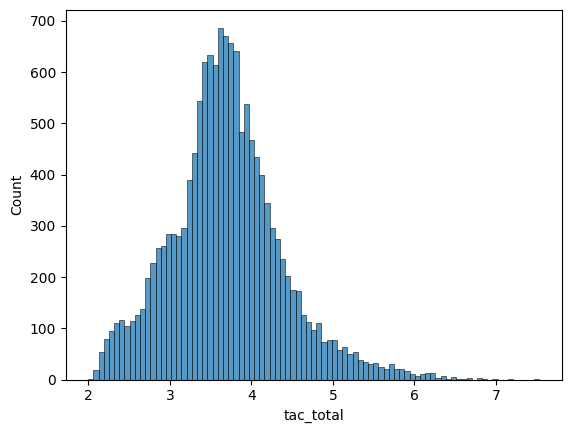

In [178]:
# tac log-normalizado
sns.histplot(np.log(com_propostas['tac_total']))

In [179]:
tac_total = np.exp(np.mean(np.log1p(com_propostas['tac_total'])))

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\1269242172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


<Axes: xlabel='spread_total', ylabel='Count'>

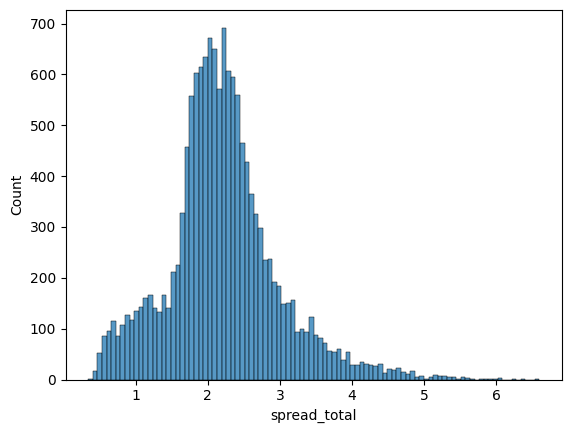

In [180]:
## tac
media = np.mean(com_propostas['spread_total'])
desvio = np.std(com_propostas['spread_total'])
zscores = np.abs(com_propostas['spread_total'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# tac log-normalizado
sns.histplot(np.log(com_propostas['spread_total']))

In [181]:
# tac log-normalizado
spread_total = np.exp(np.mean(np.log1p(com_propostas['spread_total'])))

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\2396438210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


<Axes: xlabel='CMSRepassada', ylabel='Count'>

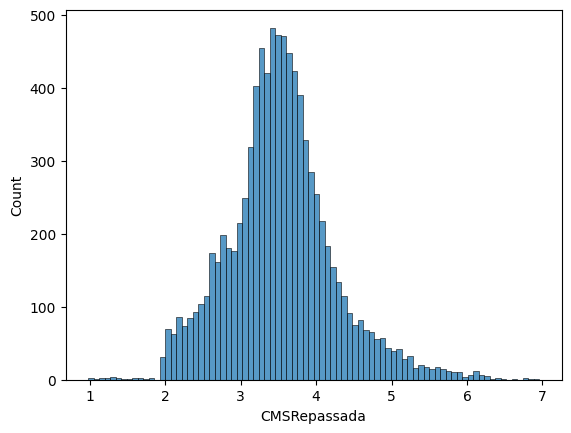

In [182]:
# CMSRepassada

media = np.mean(com_propostas['CMSRepassada'])
desvio = np.std(com_propostas['CMSRepassada'])
zscores = np.abs(com_propostas['CMSRepassada'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# CMSRepassada log-normalizado
sns.histplot(np.log(com_propostas['CMSRepassada']))

In [183]:
cms_repassada = np.exp(np.mean(np.log1p(com_propostas['CMSRepassada'])))

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\391269926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


<Axes: xlabel='iof_total', ylabel='Count'>

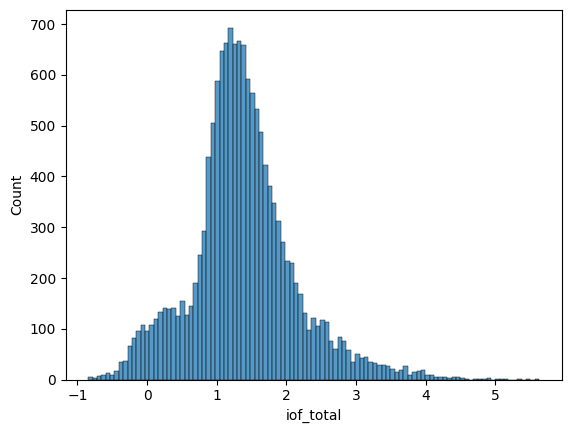

In [184]:
# iof_total

media = np.mean(com_propostas['iof_total'])
desvio = np.std(com_propostas['iof_total'])
zscores = np.abs(com_propostas['iof_total'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# iof_total log-normalizado
sns.histplot(np.log(com_propostas['iof_total']))

In [185]:
iof_total = np.exp(np.mean(np.log1p(com_propostas['iof_total'])))

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\2995311854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


<Axes: xlabel='disbursed_issue_amount', ylabel='Count'>

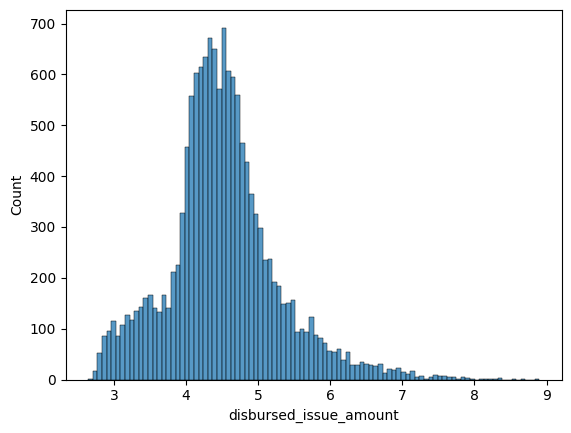

In [186]:
# disbursed_issue_amount

media = np.mean(com_propostas['disbursed_issue_amount'])
desvio = np.std(com_propostas['disbursed_issue_amount'])
zscores = np.abs(com_propostas['disbursed_issue_amount'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# disbursed_issue_amount log-normalizado
sns.histplot(np.log(com_propostas['disbursed_issue_amount']))

In [187]:
disbursed_issue_amount = np.exp(np.mean(np.log1p(com_propostas['disbursed_issue_amount'])))

In [188]:
disbursed_issue_amount

92.90785210686101

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\335641234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


<Axes: xlabel='CMSComercial', ylabel='Count'>

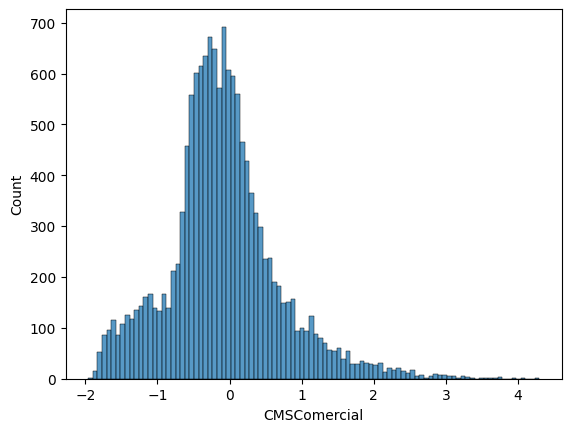

In [189]:
# CMSComercial

media = np.mean(com_propostas['CMSComercial'])
desvio = np.std(com_propostas['CMSComercial'])
zscores = np.abs(com_propostas['CMSComercial'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# CMSComercial log-normalizado
sns.histplot(np.log(com_propostas['CMSComercial']))

In [190]:
CMSComercial = np.exp(np.mean(np.log1p(com_propostas['CMSComercial'])))

In [191]:
# mcu

media = np.mean(com_propostas['mcu'])
desvio = np.std(com_propostas['mcu'])
zscores = np.abs(com_propostas['mcu'] - media / desvio)
com_propostas['outliers'] = np.where(zscores >= 3, True, False)
# mcu log-normalizado
mcus_sem_outliers = com_propostas[com_propostas['outliers'] == False]

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_17396\333450745.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_propostas['outliers'] = np.where(zscores >= 3, True, False)


In [192]:
com_propostas.positivo.value_counts()

positivo
lucro       8071
prejuizo    6397
Name: count, dtype: int64

<Axes: xlabel='mcu', ylabel='Count'>

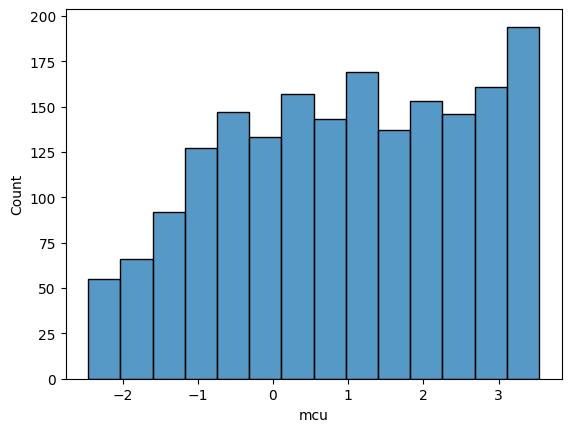

In [193]:
sns.histplot(mcus_sem_outliers['mcu'])

In [194]:
np.exp(np.mean(np.log1p(com_propostas['mcu'])))

c:\Users\Cleiton - Financeiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


9.245675421963652

In [195]:
# com_propostas['mcu'] = (
#     #pvu
#     com_propostas['tac_total'] + com_propostas['spread_total']
    
#     #cvu
#     - (
#         com_propostas['custo_consult']
#         + com_propostas['custo_formalizacao']
#         + com_propostas['custo_averacao']
#         + com_propostas['CMSRepassada']
#         + com_propostas['CMSComercial']
#         + com_propostas['iof_total']
#     )
# )


custo_formalizacao = 2.85
custo_averbacao = 0.65
cms_repassada
CMSComercial
iof_total
consult_counts


2

In [196]:
pvu = tac_total + spread_total
cvu = custo_formalizacao \
    + custo_averbacao \
    + cms_repassada \
    + CMSComercial   \
    + consult_counts * .25

In [197]:
consult_counts

2

In [198]:
tac_total

39.04293833833432

In [199]:
spread_total

10.421585312787368

In [200]:
CMSComercial

2.051995093444622

In [201]:
cms_repassada

35.29605115314606

In [202]:
cvu

41.348046246590684

In [203]:
pvu

49.46452365112168

In [204]:
mcu = pvu - cvu
mcu

8.116477404530997

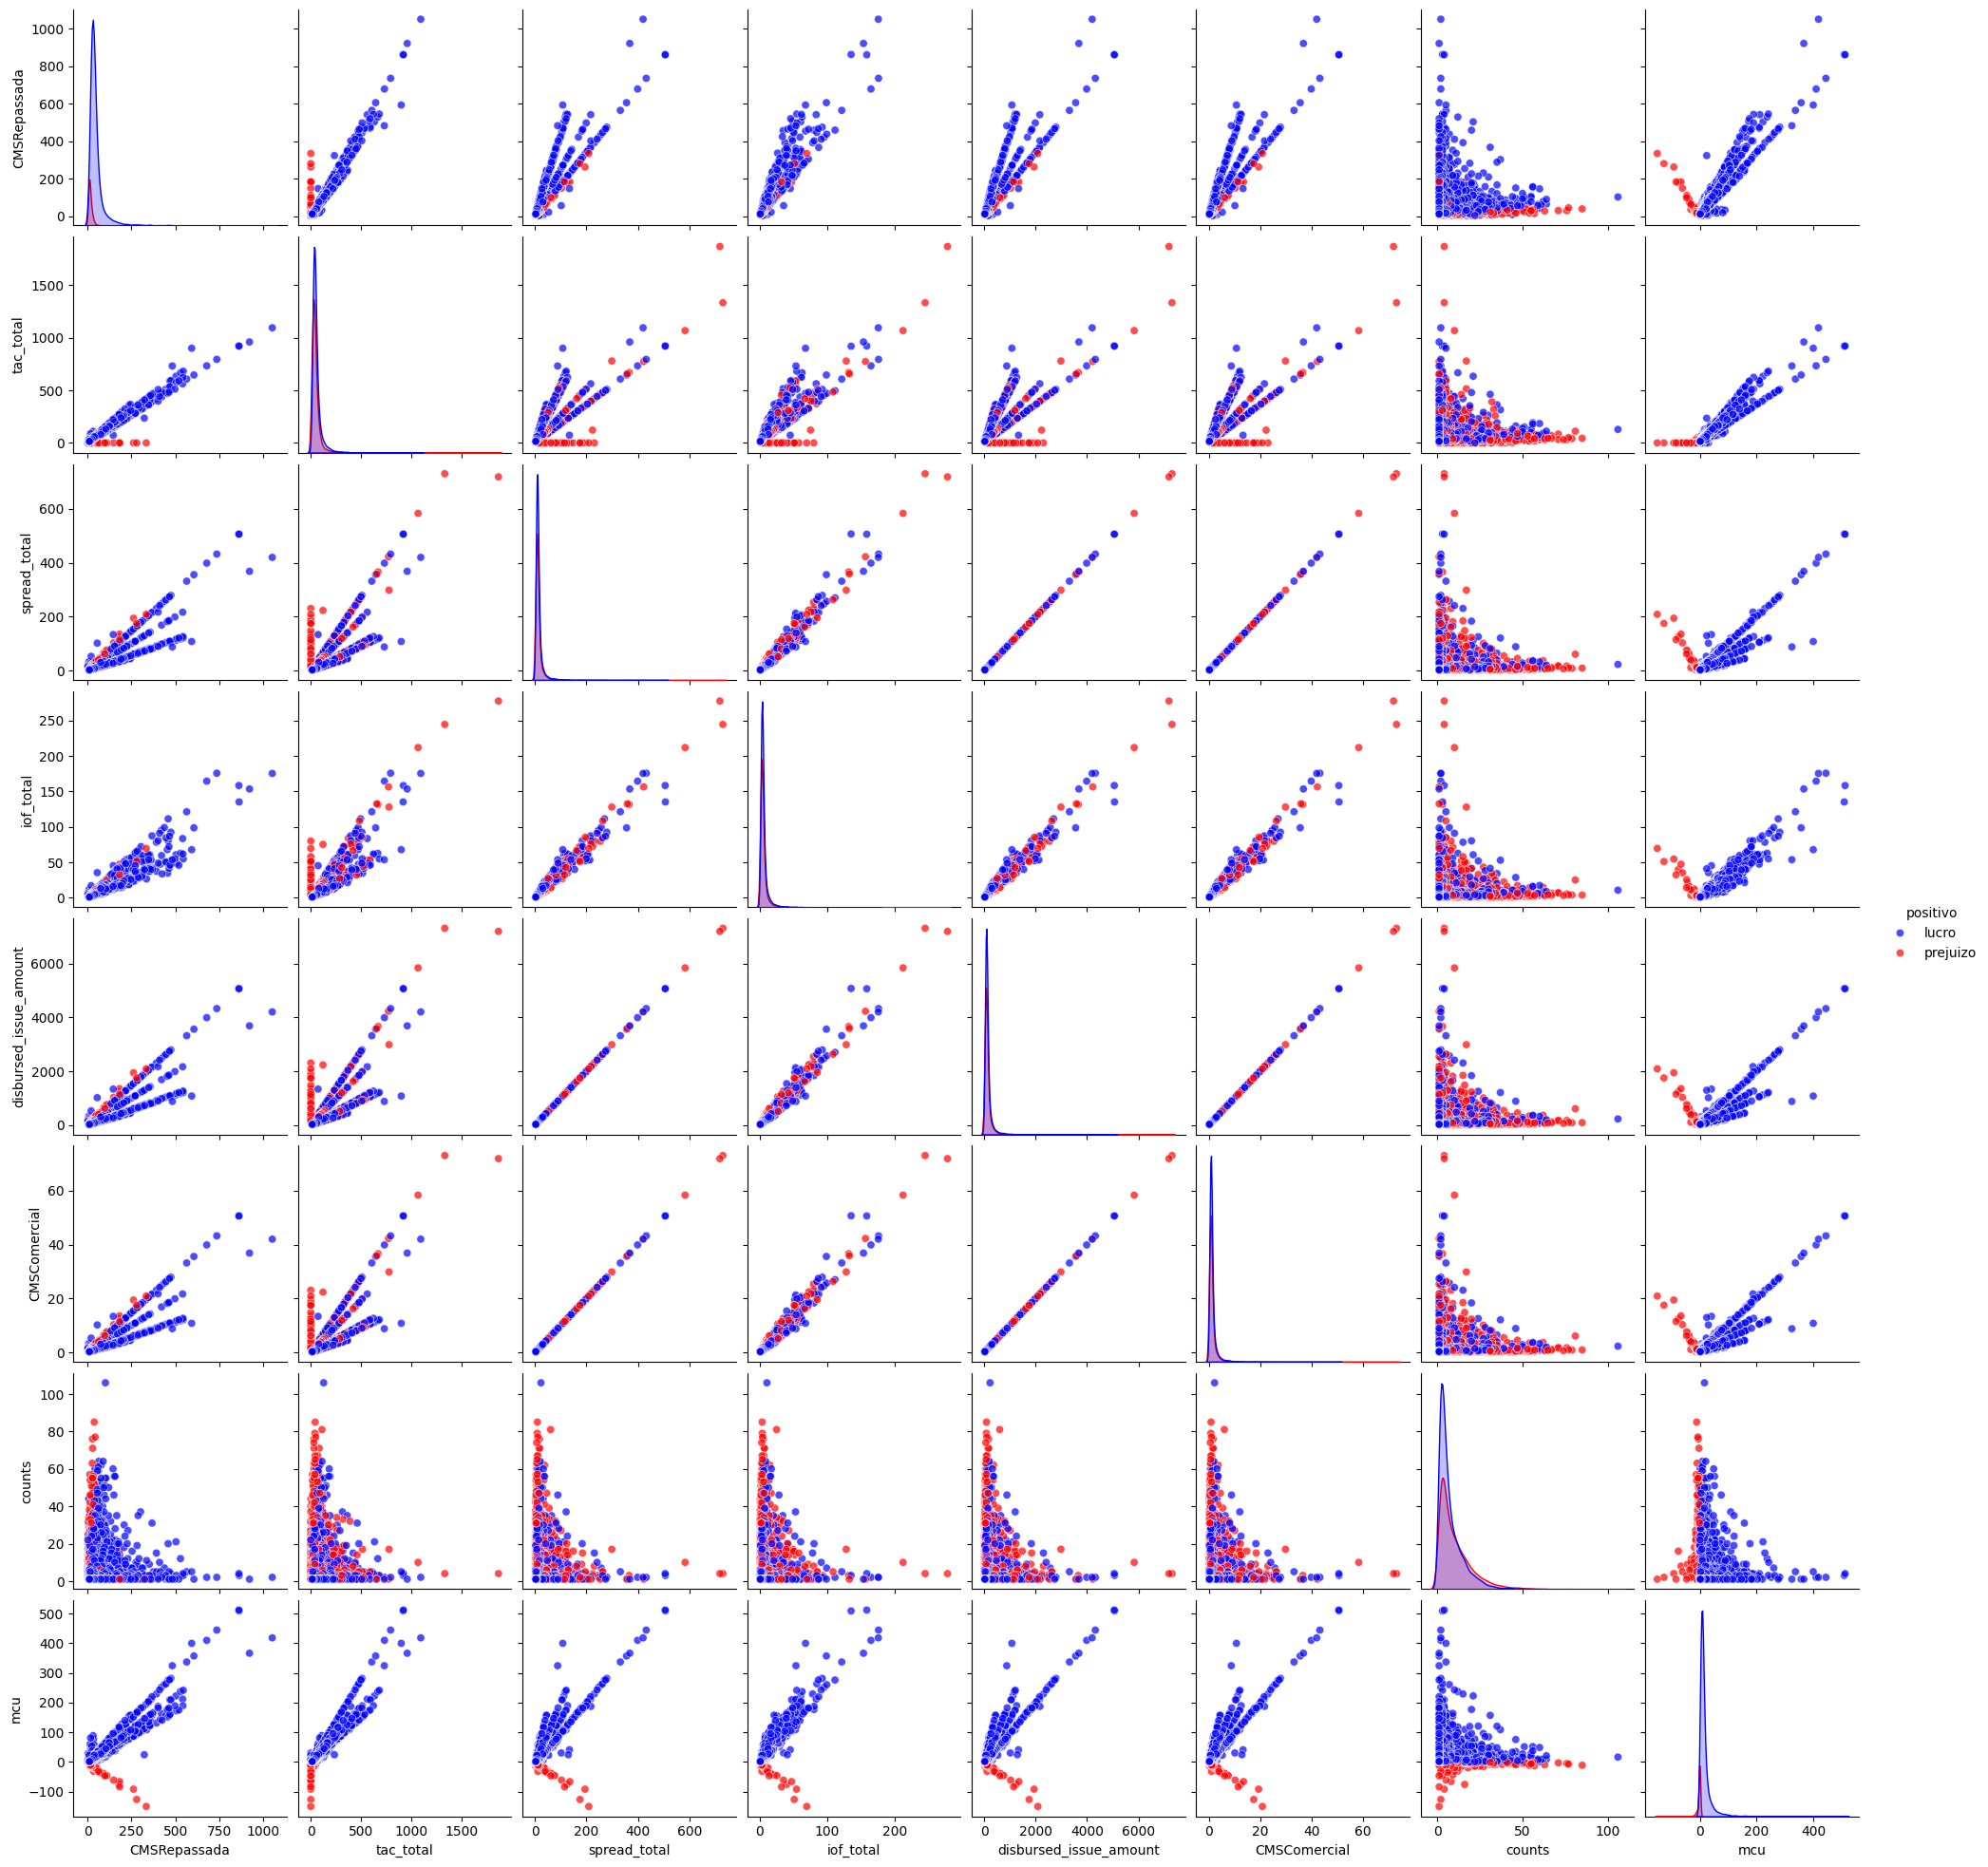

In [205]:
sns.pairplot(
    com_propostas[
        [
            "CMSRepassada",
            "tac_total",
            "spread_total",
            "iof_total",
            "disbursed_issue_amount",
            "CMSComercial",
            "counts",
            "mcu",
            "positivo"
        ]
    ],
    hue="positivo",      
    diag_kind="kde",     
    palette={'prejuizo':'red',
           'lucro' : 'blue'},
           plot_kws=dict(alpha=.7)  
)

In [206]:
com_propostas[[
                                                                    "tac_total",
                                                                    "iof_total",
                                                                    "disbursed_issue_amount",
                                                                    "CMSComercial",
                                                                    "CMSRepassada",
                                                                    "counts",
                                                                    "mcu"
                                                                    
                                                                ]
                                                            ].corr()

,tac_total,iof_total,disbursed_issue_amount,CMSComercial,CMSRepassada,counts,mcu
tac_total,1.000000,0.875199,0.814994,0.814994,0.981108,-0.018483,0.948870
iof_total,0.875199,1.000000,0.982832,0.982832,0.921955,-0.037578,0.901115
disbursed_issue_amount,0.814994,0.982832,1.000000,1.000000,0.876488,-0.046104,0.860796
CMSComercial,0.814994,0.982832,1.000000,1.000000,0.876488,-0.046104,0.860796
CMSRepassada,0.981108,0.921955,0.876488,0.876488,1.000000,-0.025262,0.920766
counts,-0.018483,-0.037578,-0.046104,-0.046104,-0.025262,1.000000,-0.103818
mcu,0.948870,0.901115,0.860796,0.860796,0.920766,-0.103818,1.000000


#### Correlacoes entre o MCUs e CVUs (entre contratos digitados)

I - Quantidade de consultas:

Nao existe correlacao clara e fore entre o mcu e a quantidade de consultas. Quanto a este ponto, na verdade, parece haver um cluster (uma tabela) em que o mcu retorna negativo.
Após a limpeza, a quantidade de consultas por contrato digitado nao mostrou um aumento preocupante (2 por contrato), e, que, aproximadamente 70% do contratos digitados geram MCU positivo.
A causa mais provável entre o MCU negativo é uma tabela em específico.

O foco deve ir para padroes em propostas que nao geram consultas.

Revendo detalhes

In [207]:
(com_propostas['counts'].sum() + sem_propostas['counts'].sum()) * .25

571652.25

In [208]:
com_propostas['mcu'].sum()

127453.71370000001

In [209]:
com_propostas.shape[0]/(com_propostas['counts'].sum() + sem_propostas['counts'].sum())

0.006327273267970169

98% das consultas realizadas nao geram nenhuma proposta.

In [210]:
sem_propostas

,CPF_consulta,provider_pagas,proventos_pagas,provider_consulta,CPF_storm,CMSRepassada,tac,tac_total,spread,spread_total,iof_total,iof_rate,disbursed_issue_amount,CMSComercial,CPF,counts,custo_averacao,custo_formalizacao,custo_consult
0,2429916100,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2429916100,1,0.65,2.86,0.25
1,9702514916,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9702514916,1,0.65,2.86,0.25
2,2483824200,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2483824200,1,0.65,2.86,0.25
3,40378791826,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,40378791826,1,0.65,2.86,0.25
4,22858008,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,22858008,3,0.65,2.86,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043378,22883234850,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,22883234850,1,0.65,2.86,0.25
1043379,70132046172,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,70132046172,1,0.65,2.86,0.25
1043380,1376526077,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1376526077,1,0.65,2.86,0.25
1043381,33473593800,NaN,NaN,bms,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,33473593800,1,0.65,2.86,0.25


Calcular ponto de equilíbrio

Se MCU < 0, a margem é negativa ou igual a zero, não há PE viável

PE = PE_unidade * PV

PE_unidade = CF / MCU

PV = Preço venda por unidade
CF = Custo fixo total

In [211]:
tac_total

39.04293833833432

In [212]:
spread_total

10.421585312787368

In [213]:
cms_repassada

35.29605115314606

In [214]:
CMSComercial

2.051995093444622

In [215]:
cvu

41.348046246590684

In [216]:
cf

571652.25

In [217]:
mcu = pvu - cvu

In [218]:
mcu

8.116477404530997

In [219]:
cf

571652.25

In [220]:
pe_unidade = cf / mcu
pe_unidade

70431.07761020526

In [221]:
PET = pe_unidade * pvu
PET

3483839.704223985

Se total_desembolsado < PET, então a produção é deficitária. Motivo: CF são extremamnte altos.

In [222]:
# neste caso:
com_propostas['mcu'].sum() - (com_propostas['counts'].sum() + sem_propostas['counts'].sum()) * .25


-444198.5363

Respondidas:

1 - Existe lucro ?
Não, conforme PE seria necessário produção 3x maior.

2 - Quais fatores estão associados, e, quais tem maior impacto?
    2.1. Custo fixo elevado (baixa conversão nas consultas)
    2.2. Quanto as propostas aprovadas:
        2.2.1 - Metade dá prejuízo (% de comissão repassada e comissão comercial)

3 - Como reverter o quadro?
    3.1 - Quanto ao custo fixo, aumentar a conversão
    3.2 - Quanto as propostas aprovadas, revisar políticas de comissionamento.

4 - Recomendações quanto às consultas:


5 - Previsão de redução na conversão


6 - Desenvolver fórmula para acompanhamento de métrica

PET = (CF / MCU) * PVU

PET = (CF / ((tac + spread) - (formalização + averbação + comissão repassada + comissão comercial + custo por consulta))) * (tac + spread)

PET = (571652.25 / ((39.04 + 10.42) - (0.65 + 2.85 + 35.29 + 2.05 + 0.50))) * (39.04 + 10.42)


In [242]:
num_consultas = com_propostas['counts'].sum() + sem_propostas['counts'].sum()
# taxa_conversao = 0.006

# num_consultas = 200000
taxa_conversao = 0.006


In [244]:
# PET = ((571652.25 / 0.0067) / ((39.04 + 10.42) - (0.65 + 2.85 + 35.29 + 2.05 + 0.50))) * (39.04 + 10.42)
PET = (((num_consultas * .25)) / ((39.04 + 10.42) - (0.65 + 2.85 + 35.29 + 2.05 + 0.50))) * (39.04 + 10.42)
PET

3482009.887315269